# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [407]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

---
## 2. Load data

In [408]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [409]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,price_change_var_1_2,price_change_var_2_3,price_change_var_1_3,price_change_fix_1_2,price_change_fix_2_3,price_change_fix_1_3,churn
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,42.497907,12.218665,8.145777,-28.258287,7.301680e+06,4.274168e+06,-70.000000,2.213347e+09,24.999991,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,44.444710,0.000000,0.000000,-99.999322,1.476000e+07,0.000000e+00,-99.999998,4.444471e+09,0.000000,0
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,44.444710,0.000000,0.000000,-47.311963,1.677980e+07,8.840900e+06,-99.999998,4.444471e+09,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [410]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [411]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


### Lagging Price Data

### Moving Averages

### The number of days since the start date

In [412]:
df['days_to_renewal'] = (df['date_renewal'] - df['date_activ']).dt.days
df['days_to_end'] = (df['date_end'] - df['date_activ']).dt.days

## 4. Random Forest Model

In [413]:
df = pd.merge(diff, df, on='id')

In [414]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14605 entries, 0 to 14604
Data columns (total 70 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   id                               14605 non-null  object        
 1   offpeak_diff_dec_january_energy  14605 non-null  float64       
 2   offpeak_diff_dec_january_power   14605 non-null  float64       
 3   Unnamed: 0                       14605 non-null  int64         
 4   channel_sales                    14605 non-null  object        
 5   cons_12m                         14605 non-null  int64         
 6   cons_gas_12m                     14605 non-null  int64         
 7   cons_last_month                  14605 non-null  int64         
 8   date_activ                       14605 non-null  datetime64[ns]
 9   date_end                         14605 non-null  datetime64[ns]
 10  date_modif_prod                  14605 non-null  datetime6

In [415]:
# Identify categorical columns and apply one-hot encoding
categorical_columns = ['channel_sales', 'origin_up', 'has_gas']  # Replace with actual categorical columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# List of datetime columns to be transformed
date_columns = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal', 'price_date', 'price_date_y', 'price_date_x'] 

# Calculate the number of days since the first date in each column
for column in date_columns:
    df[column] = pd.to_datetime(df[column])
    min_date = df[column].min()
    print(min_date)
    df[column] = (df[column] - min_date).dt.days

df.info()

2003-05-09 00:00:00
2016-01-28 00:00:00
2003-05-09 00:00:00
2013-06-26 00:00:00
2015-11-01 00:00:00
2015-08-31 14:24:00
2015-06-01 06:32:43.636363520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14605 entries, 0 to 14604
Data columns (total 80 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              14605 non-null  object 
 1   offpeak_diff_dec_january_energy                 14605 non-null  float64
 2   offpeak_diff_dec_january_power                  14605 non-null  float64
 3   Unnamed: 0                                      14605 non-null  int64  
 4   cons_12m                                        14605 non-null  int64  
 5   cons_gas_12m                                    14605 non-null  int64  
 6   cons_last_month                                 14605 non-null  int64  
 7   date_activ                                 

In [416]:
# Calculate the correlation matrix
numerical_data = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_data.corr()

# Calculate the correlation between 'churn' and all other variables
churn_correlation = correlation_matrix['churn']

# Sort the correlations in descending order
sorted_correlations = churn_correlation.abs().sort_values(ascending=False)

# Display the correlations
print("Correlation with 'churn':")
sorted_correlations

Correlation with 'churn':


churn                              1.000000
margin_net_pow_ele                 0.095780
margin_gross_pow_ele               0.095733
date_activ                         0.074831
num_years_antig                    0.074172
                                     ...   
forecast_cons_year                 0.002567
imp_cons                           0.001593
offpeak_diff_dec_january_energy    0.001060
Unnamed: 0                         0.000426
price_date_x                       0.000082
Name: churn, Length: 66, dtype: float64

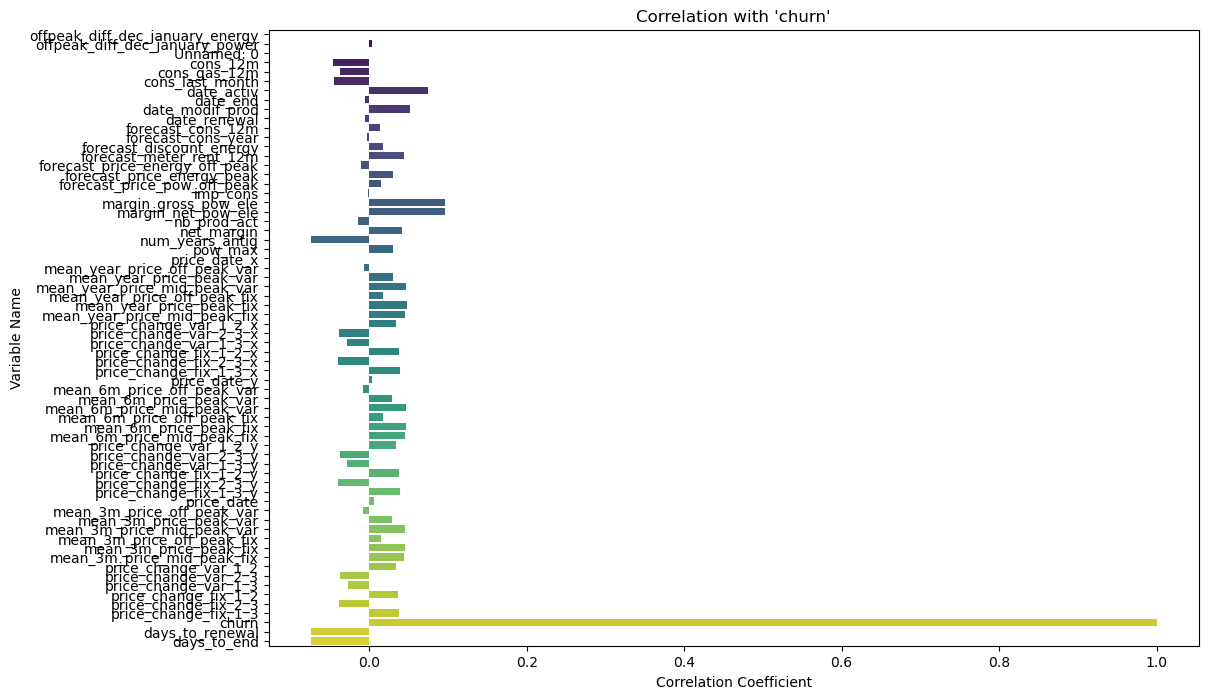

In [417]:
# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=churn_correlation, y=churn_correlation.index, palette="viridis")
plt.title("Correlation with 'churn'")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Variable Name")
plt.show()

In [418]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define the features and target variable
features = df.columns.difference(['churn', 'id'])  # All columns except 'churn'
target = 'churn'

# Split the data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42, criterion='gini', class_weight="balanced")
clf.fit(X_train, y_train)
y_probs = clf.predict_proba(X_test)

# Make predictions on the test set
# y_pred = clf.predict(X_test)

accuracy = []
precision = []
recall = []
f1 = []
roc_auc = []

for i in np.arange(0, 1, 0.1):
    y_pred = y_probs[:, 1] > i
    # Evaluate the model using various metrics
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

# Print the evaluation metrics
print("Best cutoff for each metric")
print(f"Accuracy: {max(accuracy):.2f} with {np.argmax(accuracy)*0.1}")
print(f"Precision: {max(precision):.2f} with {np.argmax(precision)*0.1}")
print(f"Recall: {max(recall):.2f} with {np.argmax(recall)*0.1}")
print(f"F1 Score: {max(f1):.2f} with {np.argmax(f1)*0.1}")
print(f"ROC AUC: {max(roc_auc):.2f} with {np.argmax(roc_auc)*0.1}\n")

# Print the evaluation metrics for best f1 score model
print("Model with the best f1 score")
print(f"Accuracy: {accuracy[np.argmax(f1)]:.2f}")
print(f"Precision: {precision[np.argmax(f1)]:.2f}")
print(f"Recall: {recall[np.argmax(f1)]:.2f}")
print(f"F1 Score: {f1[np.argmax(f1)]:.2f}")
print(f"ROC AUC: {roc_auc[np.argmax(f1)]:.2f}\n")

# Advantages and Disadvantages of Random Forest
# Advantages
print("Advantages of Random Forest:")
print("- Random Forest is an ensemble model, which combines multiple decision trees to provide accurate predictions.")
print("- It can handle a large number of features and is less prone to overfitting.")
print("- Random Forest can capture complex relationships between features.")
print("- It provides feature importance scores, helping to identify key predictors.")

# Disadvantages
print("\nDisadvantages of Random Forest:")
print("- Random Forest can be computationally expensive, especially with many trees and features.")
print("- The model's complexity can make interpretation challenging.")
print("- It may not perform well if the data has a highly imbalanced class distribution.")

Best cutoff for each metric
Accuracy: 0.90 with 0.4
Precision: 1.00 with 0.5
Recall: 0.99 with 0.0
F1 Score: 0.29 with 0.2
ROC AUC: 0.67 with 0.0

Model with the best f1 score
Accuracy: 0.86
Precision: 0.32
Recall: 0.27
F1 Score: 0.29
ROC AUC: 0.67

Advantages of Random Forest:
- Random Forest is an ensemble model, which combines multiple decision trees to provide accurate predictions.
- It can handle a large number of features and is less prone to overfitting.
- Random Forest can capture complex relationships between features.
- It provides feature importance scores, helping to identify key predictors.

Disadvantages of Random Forest:
- Random Forest can be computationally expensive, especially with many trees and features.
- The model's complexity can make interpretation challenging.
- It may not perform well if the data has a highly imbalanced class distribution.


Confusion Matrix:
[[2444  176]
 [ 220   81]]


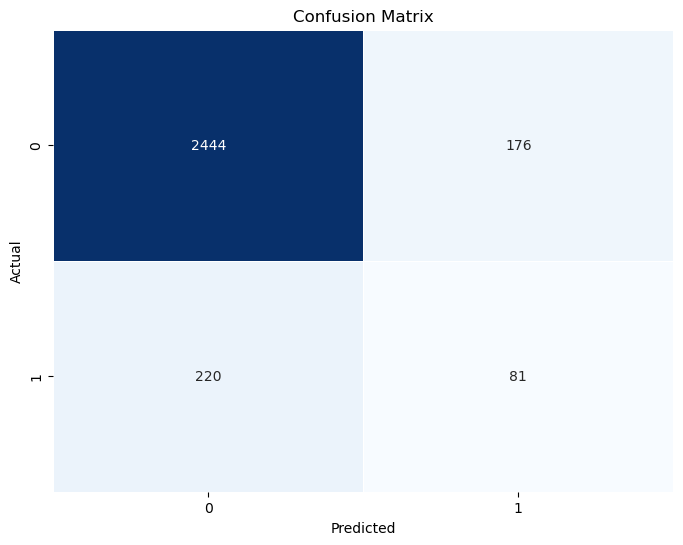

In [419]:
y_pred = y_probs[:, 1] > 0.2 # Using 0.2 as it maximizes f1 score
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Create a custom confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

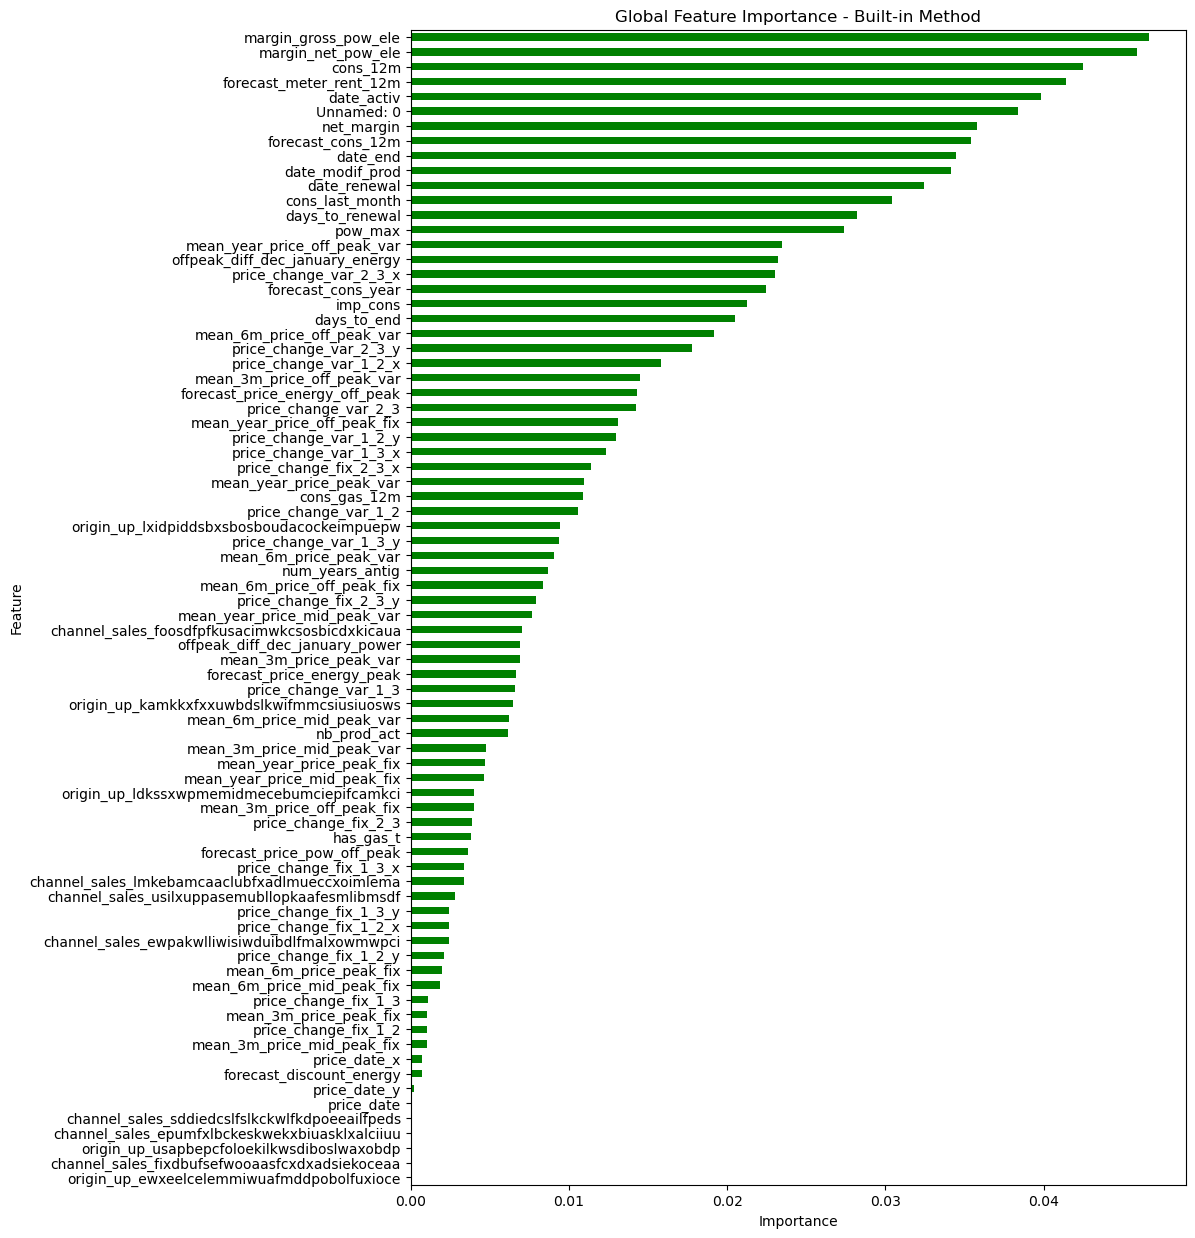

In [420]:
# Create a larger figure by specifying the figsize parameter
plt.figure(figsize=(10, 15))  # Adjust the width (10) and height (6) as needed

# Your existing code to create the horizontal bar plot
global_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

# Show the plot
plt.show()

In [427]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define the features and target variable
features = df.columns.difference(['churn',
                                  'id',
                                  'origin_up_ewxeelcelemmiwuafmddpobolfuxioce',
                                  'channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa',
                                  'origin_up_usapbepcfoloekilkwsdiboslwaxobdp',
                                  'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu',
                                  'channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds',                                
                                  ]) 
target = 'churn'

# Split the data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42, criterion='gini', class_weight="balanced")
clf.fit(X_train, y_train)
y_probs = clf.predict_proba(X_test)

# Make predictions on the test set
# y_pred = clf.predict(X_test)

accuracy = []
precision = []
recall = []
f1 = []
roc_auc = []

for i in np.arange(0, 1, 0.1):
    y_pred = y_probs[:, 1] > i
    # Evaluate the model using various metrics
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

# Print the evaluation metrics
print("Best cutoff for each metric")
print(f"Accuracy: {max(accuracy):.2f} with {np.argmax(accuracy)*0.1}")
print(f"Precision: {max(precision):.2f} with {np.argmax(precision)*0.1}")
print(f"Recall: {max(recall):.2f} with {np.argmax(recall)*0.1}")
print(f"F1 Score: {max(f1):.2f} with {np.argmax(f1)*0.1}")
print(f"ROC AUC: {max(roc_auc):.2f} with {np.argmax(roc_auc)*0.1}\n")

# Print the evaluation metrics for best f1 score model
print("Model with the best f1 score")
print(f"Accuracy: {accuracy[np.argmax(f1)]:.2f}")
print(f"Precision: {precision[np.argmax(f1)]:.2f}")
print(f"Recall: {recall[np.argmax(f1)]:.2f}")
print(f"F1 Score: {f1[np.argmax(f1)]:.2f}")
print(f"ROC AUC: {roc_auc[np.argmax(f1)]:.2f}\n")

# Advantages and Disadvantages of Random Forest
# Advantages
print("Advantages of Random Forest:")
print("- Random Forest is an ensemble model, which combines multiple decision trees to provide accurate predictions.")
print("- It can handle a large number of features and is less prone to overfitting.")
print("- Random Forest can capture complex relationships between features.")
print("- It provides feature importance scores, helping to identify key predictors.")

# Disadvantages
print("\nDisadvantages of Random Forest:")
print("- Random Forest can be computationally expensive, especially with many trees and features.")
print("- The model's complexity can make interpretation challenging.")
print("- It may not perform well if the data has a highly imbalanced class distribution.")

Best cutoff for each metric
Accuracy: 0.91 with 0.2
Precision: 1.00 with 0.4
Recall: 0.55 with 0.0
F1 Score: 0.32 with 0.1
ROC AUC: 0.68 with 0.0

Model with the best f1 score
Accuracy: 0.87
Precision: 0.34
Recall: 0.30
F1 Score: 0.32
ROC AUC: 0.68

Advantages of Random Forest:
- Random Forest is an ensemble model, which combines multiple decision trees to provide accurate predictions.
- It can handle a large number of features and is less prone to overfitting.
- Random Forest can capture complex relationships between features.
- It provides feature importance scores, helping to identify key predictors.

Disadvantages of Random Forest:
- Random Forest can be computationally expensive, especially with many trees and features.
- The model's complexity can make interpretation challenging.
- It may not perform well if the data has a highly imbalanced class distribution.


Accuracy: 0.87
Precision: 0.34
Recall: 0.30
F1 Score: 0.32
ROC AUC: 0.68

Confusion Matrix:
[[2441  179]
 [ 210   91]]
FPR: 0.0683206106870229
TPR: 0.3023255813953488


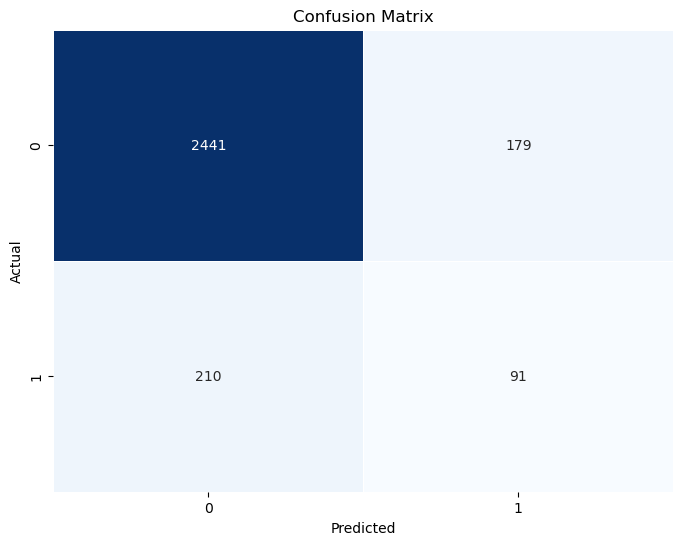

In [430]:
y_pred = y_probs[:, 1] > 0.2 # Using 0.2 as it maximizes f1 score

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]):.2f}\n")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

TN, FP, FN, TP = conf_matrix.ravel()
FPR = FP / (FP + TN)
TPR = TP / (TP + FN)
print(f"FPR: {FPR}")
print(f"TPR: {TPR}")

# Create a custom confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [442]:
X_test['churn'] = y_pred
X_test['churn_probability'] = y_probs[:, 1]
X_test.to_csv('out_of_sample_data_with_predictions.csv')

In [443]:
test_df = pd.read_csv('./out_of_sample_data_with_predictions.csv')
test_df.head()

,Unnamed: 0.1,Unnamed: 0,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,cons_12m,cons_gas_12m,cons_last_month,date_activ,...,price_change_var_1_3_x,price_change_var_1_3_y,price_change_var_2_3,price_change_var_2_3_x,price_change_var_2_3_y,price_date,price_date_x,price_date_y,churn_probability,churn
0,4947,4100,False,True,False,False,5780,0,601,2910,...,0.000000e+00,0.000000e+00,1.476000e+07,1.505598e+07,1.483437e+07,15,15,15,0.050,False
1,5868,9664,False,False,True,False,543878,1455551,63993,2678,...,8.706942e+06,8.705783e+06,1.660560e+07,1.683638e+07,1.667157e+07,15,15,15,0.050,False
2,6805,12917,False,True,False,False,4349,3884,1241,3685,...,8.915325e+06,9.033650e+06,1.689580e+07,1.708357e+07,1.697293e+07,15,15,15,0.140,False
3,1323,9519,False,False,False,False,2676,0,300,2341,...,4.102084e+01,3.857744e+01,5.933887e+01,6.846745e+01,6.334601e+01,15,15,15,0.015,False
4,11759,5101,False,True,False,False,789143,0,136148,3183,...,3.487010e+01,3.279307e+01,4.586810e+01,5.090498e+01,4.721587e+01,15,15,15,0.205,True


### Calculate a baseline revenue estimate (no intervention)

Calculate a baseline estimate of the electricity revenue for every customer for the next twelve months based on the forecast consumption and forecast
price and actual churn outcome. Call this `basecase_revenue`.

- For customers who end up churning, we should reduce our forecast revenue calculation by 91.9% to account for the customers churn some time between January 2016 and the start of March 2016. (Not knowing when they churn, a reasonable assumption for the lost revenue is the average of 100%, corresponding to churn on 1 January 2016, and 83.9%, corresponding to churn at the end of February, or 59 days into a 365 day year). Call this new variable `basecase_revenue_after_churn`, ie `basecase_revenue_after_churn` = `basecase_revenue`*(1 -0.919 * `churn`)

In [444]:
# Electricity revenue for each customer consists of energy consumption (amount * price) and the meter rent
# (the power price may also play a role, but we will ignore it for now since we need to ask the client for more data)
# Note that we need to reverse the log10-transformation from the data cleaning step
test_df['basecase_revenue'] = (np.power(10, test_df['forecast_cons_12m']) + 1) * test_df['forecast_price_energy_off_peak'] + test_df['forecast_meter_rent_12m']

# Taking churn into account
test_df['basecase_revenue_after_churn'] = test_df['basecase_revenue'] * (1 - 0.919 * test_df['churn'])
test_df.head()

,Unnamed: 0.1,Unnamed: 0,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,cons_12m,cons_gas_12m,cons_last_month,date_activ,...,price_change_var_2_3,price_change_var_2_3_x,price_change_var_2_3_y,price_date,price_date_x,price_date_y,churn_probability,churn,basecase_revenue,basecase_revenue_after_churn
0,4947,4100,False,True,False,False,5780,0,601,2910,...,1.476000e+07,1.505598e+07,1.483437e+07,15,15,15,0.050,False,inf,inf
1,5868,9664,False,False,True,False,543878,1455551,63993,2678,...,1.660560e+07,1.683638e+07,1.667157e+07,15,15,15,0.050,False,inf,inf
2,6805,12917,False,True,False,False,4349,3884,1241,3685,...,1.689580e+07,1.708357e+07,1.697293e+07,15,15,15,0.140,False,inf,inf
3,1323,9519,False,False,False,False,2676,0,300,2341,...,5.933887e+01,6.846745e+01,6.334601e+01,15,15,15,0.015,False,1.234787e+269,1.234787e+269
4,11759,5101,False,True,False,False,789143,0,136148,3183,...,4.586810e+01,5.090498e+01,4.721587e+01,15,15,15,0.205,True,inf,inf


## Calculate the estimated benefits and costs of intervention

Now, pick a cut-off probability (eg 0.5) so that:

- Customers with a higher churn probability than the cut-off get a discount, and
- Customers below the churn-probability do not get a discount.

From this, calculate the revenue of the intervention scenario assuming:
- All customers who are offered a discount accept it
- Customers who do receive a discount are are assumed not to churn in the next twelve months (ie churn probability = 0), and therefore the retained
revenue is 0.8*`basecase_revenue` , being (1-`discount_fraction`)*`basecase_revenue`
- Customers who do not receive a discount are assumed to churn based on the observed dependent variable (ie, a 1 or 0 for whether they actually
churned or not).

Now, map out the revenue delta as a function of the cut-off probability in a graph. What cut-off probability approximately optimises the revenue outcome? Assume for these calculations that the customer does not consume more or less electricity because the price changes. In practice, we would expect that if the customer's cost goes down then their consumption might increase. We will see two counterbalancing effects at play:

- For true positives we will see revenue retention vs the no-discount scenario
- For false positives we will see reduced revenue from giving them a discount when they wouldn't in fact churn.

(False negatives represent an opportunity cost but not an actual cost difference between the two scenarios.)

The optimal cut-off point will balance the benefits from true positives against the costs of false positives. Our task is to approximately find the optimal cut-off point. We may need to make additional assumptions. If we feel the assumptions above aren't justified and that others are better then we should modify our assumptions.

In [445]:
def get_rev_delta(pred: pd.DataFrame, cutoff: float=0.5, discount: float=0.2) -> float:
    """
    Get the delta of revenues for offering discount for all customers with predicted churn risk >= cutoff
    """
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    # Churn predicted => discount is given => customer stays for full year, independent of whether the prediction
    # (false positive, "free"/unnecessary discount given) or correct
    pred.loc[pred['churn_probability'] >= cutoff, 'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # Save the revenue delta for each customer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()

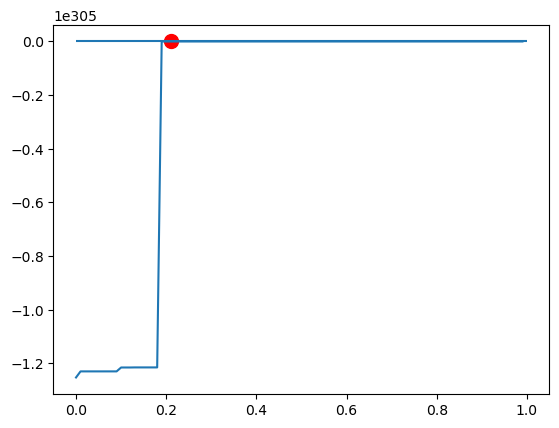

Maximum benefit at cutoff 0.21 with revenue delta of $962,630,792,205,467,885,565,357,631,681,525,811,040,021,877,839,692,651,635,817,218,182,290,860,384,065,123,764,441,068,433,342,627,849,330,402,562,015,339,015,093,521,110,983,632,814,210,166,188,694,602,027,496,744,409,853,287,353,064,450,311,444,567,014,358,140,437,172,861,237,936,675,051,307,710,779,417,047,220,151,478,175,271,826,958,324,425,846,548,598,603,310,304,841,947,732,456,243,200.00


In [446]:
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(test_df, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})

def plot_tradeoff(rev_deltas: pd.Series):
    # Plot the revenue deltas
    rev_deltas.plot()
    # Mark optimal point
    max_pred = rev_deltas.idxmax()
    plt.scatter(max_pred, rev_deltas.loc[max_pred], s=100, c='red')
    # Reference line for break-even
    plt.hlines(0, 0, 1)
    plt.show()
    print(f'Maximum benefit at cutoff {max_pred} with revenue delta of ${rev_deltas.loc[max_pred]:,.2f}')

plot_tradeoff(rev_deltas)

## Optional extra: how to select the cut-off?

Above, we decided who to offer the discount to based on a probability cut-off. Is this the optimal strategy?

- For instance, we might be offering discounts to customers who are not very profitable, thus worsening our overall margins substantially. For example, if offering a discount makes the customer unprofitable on a net margin basis then we might want to let them churn rather than save them.
- Even if we only consider revenue, this strategy might not be optimal from a revenue viewpoint. For instance, we can calculate the expected revenue impact of our strategy and prioritise customers for discounts that have a high expected revenue impact. (This means that the probability of churn might be high but they also might be valuable customers).

A general principle here is that we can afford to spend more on retaining high-value customers because the costs of losing them are higher. A very common mistake in business applications of churn is to focus on the churn probability whilst forgetting the value impact (to greater or lesser extents). We have seen many cases where our clients spend as much effort on retaining unprofitable customers as they do on retaining highly profitable customers.

In [447]:
def get_rev_delta_high_value(pred: pd.DataFrame, cutoff: float=0.5, discount: float=0.2, min_rev: float=500):
    """
    Get the delta of revenues for offering discount for all customers with predicted churn risk >= cutoff and rev
    """
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    # Churn predicted => discount is given for high-value customers => customer stays for full year, independent
    # (false positive, "free"/unnecessary discount given) or correct
    pred.loc[(pred['churn_probability'] >= cutoff) & (pred['basecase_revenue'] > min_rev),
    'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # Save the revenue delta for each customer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()

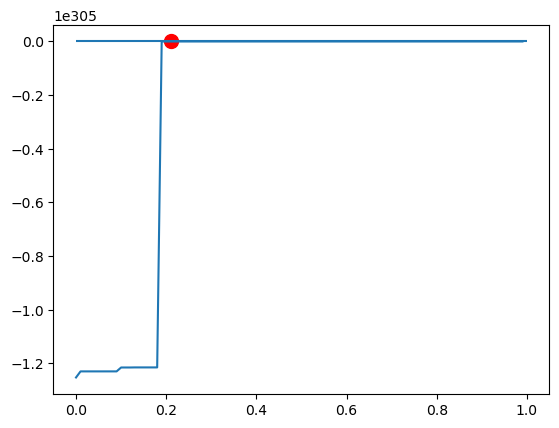

Maximum benefit at cutoff 0.21 with revenue delta of $962,630,792,205,467,885,565,357,631,681,525,811,040,021,877,839,692,651,635,817,218,182,290,860,384,065,123,764,441,068,433,342,627,849,330,402,562,015,339,015,093,521,110,983,632,814,210,166,188,694,602,027,496,744,409,853,287,353,064,450,311,444,567,014,358,140,437,172,861,237,936,675,051,307,710,779,417,047,220,151,478,175,271,826,958,324,425,846,548,598,603,310,304,841,947,732,456,243,200.00


In [448]:
## Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas_high_value = pd.Series({cutoff: get_rev_delta_high_value(test_df, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
plot_tradeoff(rev_deltas_high_value)

## 5. Evaluation of results

### Without difference between off-peak prices in December and preceding January
Accuracy: 0.90
Precision: 0.93
Recall: 0.05
F1 Score: 0.09
ROC AUC: 0.69

### With difference between off-peak prices in December and preceding January
Accuracy: 0.90
Precision: 0.92
Recall: 0.04
F1 Score: 0.07
ROC AUC: 0.67

### With days to renewal and days to end
Accuracy: 0.90
Precision: 0.91
Recall: 0.03
F1 Score: 0.06
ROC AUC: 0.68

### With changing the cut-off for predictions
Model with the best f1 score
Accuracy: 0.86
Precision: 0.32
Recall: 0.27
F1 Score: 0.29
ROC AUC: 0.67

Depending on how much is lost by losing a customer compared to giving discounts too often this parameter could be tuned to represent the companies preference for the predicions. 

### Removing the 4 most seemingly least important features
Model with the best f1 score
Accuracy: 0.87
Precision: 0.34
Recall: 0.30
F1 Score: 0.32
ROC AUC: 0.68

### Model evaluation
The model seems to perform the best when we change the cutoff to improve the f1 score and then remove the 4 least important features. The accuracy of 87-90% could be considered quite good but the f1 score and especially the recall are still quite low. 

### Profif calculations
If we assume that it costs 1 unit to give a discount and twice as much to loose a customer and a 10% churn rate we can do the following estimations of the savings. 

A. If no discounts are given we can expect to have a cost of 0.1 * 2 = 0.2 per customer.
B. If we give all customers a discount we will have a cost of 1 per customer.
C. If we give a random customer a discount with a probability p we will have a cost of p*1 + (1-p)*0.1*2 = /p=0 since it minimizes the cost in the interval [0,1]/ = 0.2 per customer.
D. We use the model: False positive rate of 0.07 and TPR = 0.3. The expected cost for using the model is therefore (1-2)*0.3 + 0.07*1 = -0.23. This means that we can save 23% of what it costs to give a discount by following the models advice. If we don't use the model it is not worth to give the discount with these values but that could change depending on how much we estimates that it costs to loose a customer and give the discount. 

### Is this problem best represented as classification or regression? 
I think it is best to treat it as a classification problem as we need to have a excplicit answer for what to do but we can certainly change the probability cut-off for when to take what decision. 

